Run the following cells to prepare your working environment:

In [1]:
%cd /content
!git clone https://github.com/mhsotoudeh/ProbUNet-Tutorial.git
# !export PYTHONPATH="${PYTHONPATH}:$PWD/ProbUNet-Tutorial"
%cd /content/ProbUNet-Tutorial

/content
Cloning into 'ProbUNet-Tutorial'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 58 (delta 21), reused 40 (delta 13), pack-reused 0
Unpacking objects: 100% (58/58), 3.83 MiB | 2.85 MiB/s, done.
/content/ProbUNet-Tutorial


In [1]:
!pip install -r requirements.txt

Ignoring pip: markers 'python_version < "3"' don't match your environment
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx512, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
^C
ERROR: Operation cancelled by user


In [2]:
%load_ext autoreload
%autoreload 2

%load_ext tensorboard

In [20]:
from data import *
from model import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import torch
from torch.utils.data import DataLoader

import json

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device is {}".format(device))

Device is cuda


## Part 1: Using Hierarchical Probabilistic U-Net for Source Reconstruction

### Train the Model

In [ ]:
!./run.sh

### Tensorboard Session

In [50]:
# %tensorboard --logdir runs/part1

### Visualize Samples

In [44]:
mpl.rc('image', cmap='hot')

np.random.seed(0)
torch.manual_seed(0)

bs = 16
k = 100  # Num of Predictions per Input

# Choose Model
model_dir = 'runs/part1'
model_stamp = '0216-1834_bg_815318_lensing_64_32-32-64-128-128-128'
model_suffix = '160'

# Choose Data File
data_dir = 'utils/flip/32768-12288-2899'
dataset_name = '64_test'

# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is {}".format(device))

Device is cuda


In [45]:
# Load Model & Loss
model = torch.load('{}/{}/model{}.pth'.format(model_dir, model_stamp, model_suffix), map_location=torch.device(device))
model.eval()

criterion = torch.load('{}/{}/loss{}.pth'.format(model_dir, model_stamp, model_suffix), map_location=torch.device(device))
criterion.eval()


# Load Args
with open('{}/{}/args.json'.format(model_dir, model_stamp), 'r') as f:
    args = json.load(f)


# Load Data
test_data, transdict = prepare_data('{}/{}.npy'.format(data_dir, dataset_name), normalization=None)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [46]:
data_iterator = iter(test_loader)

observations, truths = next(data_iterator)
observations, truths = observations.to(device), truths.to(device)

with torch.no_grad():
    preds, infodicts = model(observations, truths, times=k, insert_from_postnet=False)

In [47]:
observations.shape, truths.shape, preds.shape

(torch.Size([16, 1, 64, 64]),
 torch.Size([16, 1, 64, 64]),
 torch.Size([16, 100, 64, 64]))

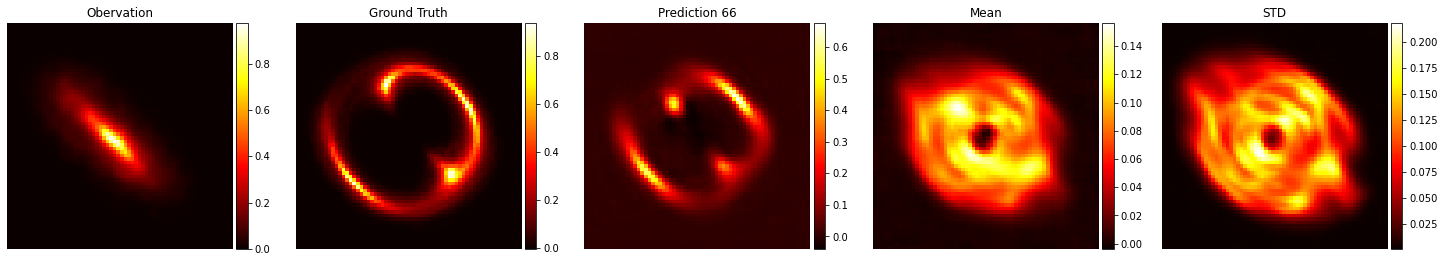

In [49]:
idx = 12
pr = 65

fig, axs = plt.subplots(1, 5, figsize=(25,5))

# fig.suptitle('Training Dataset (each row is a training example)', size=14)
axs[0].set_title('Obervation')
axs[1].set_title('Ground Truth')
axs[2].set_title('Prediction {}'.format(pr+1))
axs[3].set_title('Mean')
axs[4].set_title('STD')

im0 = axs[0].imshow(observations[idx].squeeze().cpu().numpy())
im1 = axs[1].imshow(truths[idx].squeeze().cpu().numpy())
im2 = axs[2].imshow(preds[idx][pr].cpu().numpy())
im3 = axs[3].imshow(preds[idx].mean(dim=0).cpu().numpy())
im4 = axs[4].imshow(preds[idx].std(dim=0).cpu().numpy())

imlist = [im0, im1, im2, im3, im4]
for i, axi in enumerate(axs.ravel()):
    axi.set_axis_off()

    divider = make_axes_locatable(axi)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imlist[i], cax=cax, orientation='vertical')

    imlist.append(cax)

plt.show()